In [3]:
from google.colab import drive
from google.colab import files

#Read and write files directly from google drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
#install packages missing from the Colab environment
!pip install geopandas
!pip install rasterio

In [0]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import mapping, shape
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
from math import radians, degrees, sin, cos, asin, acos, sqrt


In [0]:
volcanoes = gpd.read_file('drive/My Drive/Hamish mapping/Hamish mapping/Environmental layers/Shp/Island_volcanos_wgs.shp', 
                          driver='ESRI Shapefile')
coastline = gpd.read_file('drive/My Drive/Hamish mapping/Hamish mapping/useful general mapping data - elevation and perimeter/Linea_Costa/PERFIL_Project.shp', 
                       driver='ESRI Shapefile')
point_data = pd.read_csv('drive/My Drive/Hamish mapping/Hamish mapping/Occurence data to Oct 2019/Training_data_2019_occ_move_thinned.csv')

hillshade = rasterio.open('drive/My Drive/Hamish mapping/Hamish mapping/tmp/hillshade.tif')

dem = rasterio.open('drive/My Drive/Hamish mapping/Hamish mapping/tmp/DEM_nan.tif')

In [0]:
'''
Class for the map element
'''
class galapagos_map:
  
  #Create bounding boxes when ititiating the function
  def __init__(self, volcano_dataset, island_to_plot='Archipelago', fig_size='large'):
    self.volcanoes = volcano_dataset
    self.island_to_plot = island_to_plot
    self.bounding_boxes = Bounding_Boxes(self.volcanoes)
    self.volcano_names = self.bounding_boxes.volcano_names
    self.fig_size = fig_size
  
  #Plot a basemap with the correct axes, north arrow and scale bar
  def base_map(self):
    
    #NORTH ARROW CALCULATIONS
    arrow_buffer = 0.05
    
    #Change these values empirically when the final figure sizes are decided
    #The represent the fraction of the image at which to place the base of the N arrow
    #and the 'N' text, could also apply to arrow_buffer
    arrow_length_fraction = {'large' : 25,
                             'medium' : 15,
                             'small' : 10,
                            }
    
    arrow_text_fraction = {'large' : 20,
                           'medium' : 13,
                           'small' : 8,
                          }
    
    x_diff = self.bounding_boxes.x_lim_island(self.island_to_plot)[1] - self.bounding_boxes.x_lim_island(self.island_to_plot)[0]
    arrow_x = self.bounding_boxes.x_lim_island(self.island_to_plot)[1] - (x_diff * arrow_buffer)
    y_diff = self.bounding_boxes.y_lim_island(self.island_to_plot)[1] - self.bounding_boxes.y_lim_island(self.island_to_plot)[0]
    arrow_y = self.bounding_boxes.y_lim_island(self.island_to_plot)[1] - (y_diff * arrow_buffer)
    
    
    #SCALE BAR CACULATIONS
    def great_circle(lon1, lat1, lon2, lat2):
      lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
  
      return 6371 * (acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2)))
  
    def dirty_inverse(kilometer_value):
      return((1.0/111.0)*(float(kilometer_value)))
    
    def scale_bar_coordinates(min_x, min_y, max_x, max_y):
      
      scale_x_buffer = {'large' : 0.125,
                        'medium' : 0.1,
                        'small' : 0.08,
                       }
      scale_y_buffer = {'large' : 0.1,
                        'medium' : 0.05,
                        'small' : 0.025,
                       }

      #List of possible labels for the scale bar
      scale_bar_labels = [0.25, 0.5, 0.75, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 75, 100]

      #Determine the width and height of the plot in degrees
      width_degrees = max_x - min_x
      height_degrees = max_y - min_y

      #Determine the x and y buffer for the scale bar
      scale_x_buffer = width_degrees * scale_x_buffer[self.fig_size]
      scale_y_buffer = height_degrees * scale_y_buffer[self.fig_size]

      #Determine the location of the bottom corners (L & R) of the map
      left_map_point = [min_x, min_y]
      right_map_point = [max_x, min_y]

      #Determine the width of the map in kilometers
      map_width_km = great_circle(left_map_point[0], left_map_point[1],
                                right_map_point[0], right_map_point[1])

      #Determine the right x coordinate of the scale bar
      scale_R_coord = self.bounding_boxes.x_lim_island(self.island_to_plot)[1] - scale_x_buffer

      #Make the scale bar approximately 1/5th of image by default
      scale_bar_image_fraction = 0.2

      #Compute distance of 1/5 of image in kilometers
      scale_relative_length = map_width_km * scale_bar_image_fraction

      #Find the value in scale_bar_labels closest to this value (scale_relative_length)
      closest_scale_bar_label = min(scale_bar_labels, key=lambda x:abs(x-scale_relative_length))

      #Do an inverse great circle distance computation (rather crude) to convert closest_scale_bar_label from degrees to km
      degree_shift = dirty_inverse(closest_scale_bar_label)

      #use degree_shift to compute the left x coordinate of the scale bar
      scale_L_coord = scale_R_coord - degree_shift

      #Determine the y coordinate for both the R and L corners of the scale bar
      scale_y_coord = min_y + scale_y_buffer

      '''
      Add white lines to scale bar at 0.1 to 0.4, and 0.6 to 0.8
      '''

      #Find the x coordinate of 6 points along the scale bar line
      sextiles = np.linspace(scale_L_coord, scale_R_coord, 6)

      #Define the x coordinates for the two white patches on the line
      white1_x_coords = (sextiles[1], sextiles[2])
      white2_x_coords = (sextiles[3], (sextiles[4]))

      '''
      Add text to the scale bar
      '''

      #Define the height of the text (half of the distance between the scale bar and the plot frame)
      text_y_coordinate = scale_y_coord - (scale_y_buffer/2)

      #Define a middle text label 1/3 of the way from 0 to closest_scale_bar_label
      middle_text_label = round(np.linspace(0, closest_scale_bar_label, 6)[2], 1)

      #If the middle_text_label has no decimal place, convert it to an integer
      if middle_text_label.is_integer():
        middle_text_label = int(middle_text_label)

      #list of items needed for plotting = scale_L_coord, scale_R_coord, scale_y_coord, white1_x_coords, white2_x_coords, text_y_coordinate, sextiles[2],
      #middle_text_label, closest_scale_bar_label
      return(
          {'scale_L_coord' : scale_L_coord,
           'scale_R_coord' : scale_R_coord,
           'scale_y_coord' : scale_y_coord,
           'white1_x_coords' : white1_x_coords,
           'white2_x_coords' : white2_x_coords,
           'text_y_coordinate' : text_y_coordinate,
           'middle_text_x_coord' : sextiles[2],
           'middle_text_label' : middle_text_label,
           'closest_scale_bar_label' : closest_scale_bar_label
          }
      )

    
    #Plot the base figure
    self.fig, self.ax = plt.subplots()
    
    #Plot North Arrow
    self.ax.annotate('', xy=(arrow_x, arrow_y), 
                     xytext=(arrow_x, (arrow_y-(y_diff/arrow_length_fraction[self.fig_size]))), 
                     arrowprops=dict(arrowstyle='simple', fc='k'), 
                     clip_on=True
                    )

    self.ax.text(x=arrow_x, 
                 y=(arrow_y-(y_diff/arrow_text_fraction[self.fig_size])), 
                 s='N', 
                 horizontalalignment='center'
                )
    
    #Plot scale bar
    sb_coordinates = scale_bar_coordinates(self.bounding_boxes.x_lim_island(self.island_to_plot)[0], 
                                           self.bounding_boxes.y_lim_island(self.island_to_plot)[0], 
                                           self.bounding_boxes.x_lim_island(self.island_to_plot)[1],
                                           self.bounding_boxes.y_lim_island(self.island_to_plot)[1]
                                          )
    
    scale_L_coord = sb_coordinates['scale_L_coord']
    scale_R_coord = sb_coordinates['scale_R_coord']
    scale_y_coord = sb_coordinates['scale_y_coord']
    white1_x_coords = sb_coordinates['white1_x_coords']
    white2_x_coords = sb_coordinates['white2_x_coords']
    text_y_coordinate = sb_coordinates['text_y_coordinate']
    middle_text_x_coord = sb_coordinates['middle_text_x_coord']
    middle_text_label = sb_coordinates['middle_text_label']
    closest_scale_bar_label = sb_coordinates['closest_scale_bar_label']
        
    self.ax.plot((scale_L_coord, scale_R_coord), (scale_y_coord, scale_y_coord), color='k', linestyle='-', linewidth=4),
    self.ax.plot(white1_x_coords, (scale_y_coord, scale_y_coord), color='w', linestyle='-', linewidth=2.5),
    self.ax.plot(white2_x_coords, (scale_y_coord, scale_y_coord), color='w', linestyle='-', linewidth=2.5),
    self.ax.text(scale_L_coord, text_y_coordinate, '0', ha='center'),
    self.ax.text(middle_text_x_coord, text_y_coordinate, str(middle_text_label), ha='left'),
    self.ax.text(scale_R_coord, text_y_coordinate, str(closest_scale_bar_label) + ' km', ha='left')
    
    #Zoom into desired island
    self.ax.set_xlim(self.bounding_boxes.x_lim_island(self.island_to_plot))
    self.ax.set_ylim(self.bounding_boxes.y_lim_island(self.island_to_plot))
    
    #Remove axis labels
    self.ax.axes.get_xaxis().set_ticklabels([])
    self.ax.axes.get_yaxis().set_ticklabels([])
  #Accepts a rasterio raster and matplotlib **kwargs for plt.imshow()
  def add_raster_data(self, raster_data, raster_band=1, **kwargs):
    plt.imshow(raster_data.read(raster_band), 
                   extent=(raster_data.bounds[0], raster_data.bounds[2], raster_data.bounds[1], raster_data.bounds[3]),
                   **kwargs)
  
  #Accepts point data in lat_lon coordinates
  def add_xy_data(self, x_data, y_data, **kwargs):
    plt.scatter(x_data, y_data, **kwargs)
      
  #Accepts geospatial dataframe data
  def add_vector_data(self, vector_data, **kwargs):
      vector_data.geometry.plot(ax=self.ax, **kwargs)
  
  #Add an ocean color from a matplotlib compatible color string
  def add_ocean_color(self, color):
    self.ax.set_facecolor(color)
  
  #Add attribution text to the bottom left corner of the plot
  def add_attribution_text(self, attribution_text, **kwargs):

    text_buffer_fraction = {'large' : 50,
                            'medium' : 40,
                            'small' : 30,
                           }
    
    x_diff = self.bounding_boxes.x_lim_island(self.island_to_plot)[1] - self.bounding_boxes.x_lim_island(self.island_to_plot)[0]
    y_diff = self.bounding_boxes.y_lim_island(self.island_to_plot)[1] - self.bounding_boxes.y_lim_island(self.island_to_plot)[0]
    
    text_x_buffer = x_diff / text_buffer_fraction[self.fig_size]
    text_y_buffer = y_diff / text_buffer_fraction[self.fig_size]
    
    self.ax.text(x=self.bounding_boxes.x_lim_island(self.island_to_plot)[0] + text_x_buffer,
        y=self.bounding_boxes.y_lim_island(self.island_to_plot)[0] + text_y_buffer,
        s=attribution_text, **kwargs)
  
  def add_grid(self, **kwargs):
    self.ax.grid(True, **kwargs)
  
'''
Internal class to define bounding boxes around each island
'''
class Bounding_Boxes:
  
  #Instantiate Bounding_Boxes class using vector data - this class is written specifically to accept volcano specific data
  def __init__(self, vector_data):

    #Add vector_data attribute to inspect original vector data
    self.vector_data = vector_data

    bbox = {}
    bbox['Archipelago'] = vector_data.total_bounds

    isabela_list = ['Darwin', 'Alcedo', 'Ecuador', 'South', 'Wolf']

    bbox['Isabela'] = vector_data[vector_data['Name'].isin(isabela_list)].total_bounds

    for island in list(vector_data.Name.unique()):
      bbox[island] = vector_data[vector_data['Name']==island].envelope
    self.bboxes = bbox

    #Add volcano_names class to inspect all unique volcano names (useful for plotting)
    volcano_names = list(vector_data.Name.unique()) + ['Archipelago'] + ['Isabela']
    self.volcano_names = volcano_names

  #Define a method to create matplotlib compatible xlim
  def x_lim_island(self, island, zoom_factor=0.15):

    #Define the factor by which to zoom out x axis (this could be made into two zooms L & R)
    #z_factor = 0.15 means that 15% of the total boundign box will be added to both sides
    #This scales with the size of the island to add a border to all plots
    z_factor = zoom_factor

    #Archipelago is a ndarray data type not a Shapely Polygon
    if island in ['Archipelago', 'Isabela']:
      xmin = self.bboxes[island][0]
      xmax = self.bboxes[island][2]

      zoom = (xmax - xmin) * z_factor

      #Returns xlim ready for the plt.xlim function
      return(xmin - zoom, xmax + zoom)

    #Extract coordinates from Shapely Polygon bounding boxes
    else:
      xmin = mapping(self.bboxes[island])['bbox'][0]
      xmax = mapping(self.bboxes[island])['bbox'][2]

      zoom = (xmax - xmin) * z_factor

      #Returns xlim ready for the plt.xlim function    
      return(xmin - zoom, xmax + zoom)

  #Copy of x_lim_island for the y axis
  def y_lim_island(self, island, zoom_factor=0.15):

    z_factor = zoom_factor

    if island in ['Archipelago', 'Isabela']:
      ymin = self.bboxes[island][1]
      ymax = self.bboxes[island][3]

      zoom = (ymax - ymin) * z_factor

      return(ymin - zoom, ymax + zoom)

    else:
      ymin = mapping(self.bboxes[island])['bbox'][1]
      ymax = mapping(self.bboxes[island])['bbox'][3]

      zoom = (ymax - ymin) * z_factor

      return(ymin - zoom, ymax + zoom) 

In [0]:
map_test = galapagos_map(volcanoes, 'Isabela', fig_size='small')

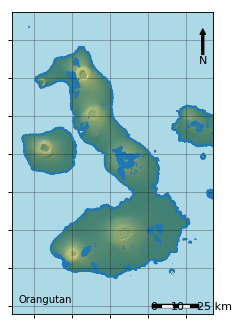

In [231]:
plt.rcParams["figure.figsize"] = [10,5]
plt.rcParams["figure.dpi"] = 80
map_test.base_map()
map_test.add_raster_data(hillshade, cmap='gray')
map_test.add_raster_data(dem, cmap='summer', alpha=0.5)
map_test.add_xy_data(point_data['Long'], point_data['Lat'], s=0.5)
map_test.add_vector_data(coastline)
map_test.add_ocean_color('lightblue')
map_test.add_attribution_text('Orangutan', size=9)
map_test.add_grid(color='k', alpha=0.3)

In [0]:
#Write up documentation for the galapagos_map_class
#Publish as a python package for practice and share this on github with james
#Use the map class for plotting with from git/clone/etc. import galapagos_map

#To move this into production of maps for print - need to define figure size (can be in inches) an dpi, then choose buffer values for different figure types